In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mlp


In [6]:
trcs = pd.read_csv("../data/trcPALMTracer-Interaction-MSD-MaxDistance3000-Filter_ROI1.txt",  sep='\t', header=[2], skiprows=0)

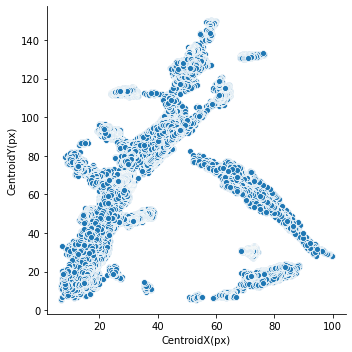

In [8]:
sns.relplot(x="CentroidX(px)", y="CentroidY(px)", data=trcs);

In [9]:
trackHeaderName = 'Index'
trcs[trackHeaderName] = trcs['Track']
InteractionDistanceHeaderName = "InteractionDistance"
InteractionDurationHeaderName = "InteractionDuration"
trackHeaderName ='Index'                                             #setea los nombres de cada variable o columna.

planeDuration = 0.05 #@param {type:"number"}
xyPixelSize = 0.160 #@param {type:"number"}
graphUnitSize = 600 #@param {type:"slider", min:50, max:1000, step:25}       #Setea los parametros de acquisicion

trcs['time'] = trcs['Plane']*planeDuration
trcs['x'] = trcs['CentroidX(px)']*xyPixelSize
trcs['y'] = trcs['CentroidY(px)']*xyPixelSize
trcs['Wavelength'] = trcs['Wavelength(nm)']        #Multiplico cada variable de track por los paramertros.

threshold_dimer =  90#@param {type:"number"}
threshold_coconfined=3000#@param {type:"number"}
threshold_free = 3001
confinementLevels = {1:'Dimer', 2:'Co-Confined', 3:'Free'}                   #Seteo threshold de interacion para un Hiden-Markov Model

trcs['ConfinementLevel'] = np.where(trcs[InteractionDistanceHeaderName]<threshold_dimer, 1,2)
trcs['ConfinementLevel'] = np.where(trcs[InteractionDistanceHeaderName]<threshold_coconfined,trcs['ConfinementLevel'], 3)
trcs['ConfinementLevel'] = np.where(trcs[InteractionDistanceHeaderName]<threshold_free,trcs['ConfinementLevel'], 3)

trackNums = pd.unique(trcs['Index'])
print(str(len(trackNums)) + " Tracks")

641 Tracks


In [10]:
print('Analyzing tracks...')

theseLocs = pd.DataFrame(columns=trcs.columns) 
theseConfinedLocs = pd.DataFrame(columns=trcs.columns)
interactions = pd.DataFrame()

allLocs = pd.DataFrame(columns=trcs.columns)
allConfinedLocs = pd.DataFrame(columns=trcs.columns)

trackAverageWavelengths = {}
interactionDeltaWavelengths = {}
trackLengths = {}

trackOffRateColumns =["Track", "TrackLength","AvgWavelength","PlanesInConfinement1", "PlanesInConfinement2", "PlanesInConfinement3", "Transitions_0to1", "Transitions_0to2", "Transitions_1to0", "Transitions_1to2", "Transitions_2to1", "Transitions_2to0","OffRate"]
trackOffRates = pd.DataFrame(columns = trackOffRateColumns)
allInteractions = pd.DataFrame(columns = ["Plane","Track1", "Track2", "Track1_LocID","Track2_LocID", "Track1_Wavelength","Track2_Wavelength","InteractionDistance","ConfinementLevel"])

minWavelengthVal = -1
maxWavelengthVal = 1000 # >1000 wavelength will be multiple matched, unmatched or rejected. For now, bin them all together, as they represent values of wavelength that don't actively contribute to the wavelength assignment
def filterWavelengths(col):
    _col = col
    if _col > maxWavelengthVal:
        _col = minWavelengthVal
    return _col

def trackAverageWavelength(_locs):
    locsWithWavelength = _locs[(_locs[('Wavelength')]>minWavelengthVal)]
    avgWavelength = locsWithWavelength['Wavelength'].mean()

    if math.isnan(avgWavelength):
        avgWavelength = -1

    return round(avgWavelength)
  
def trackLength(_locs):
  return len(_locs)

def locsInTrack(trackNum):
    return trcs[(trcs['Index']==trackNum)]

Analyzing tracks...


In [13]:
#Save filtered wavelength values in a new column
trcs['Wavelength'] = round(trcs['Wavelength(nm)'].apply(filterWavelengths))

#Do some rough calculations for each track before 
for trackNum in trackNums:
  theseLocs = locsInTrack(trackNum)

  trackAvgWavelength = trackAverageWavelength(theseLocs)
  trackAverageWavelengths[trackNum] = trackAvgWavelength
  trackLengths[trackNum] = trackLength(theseLocs)

print('Pre-analysis complete. Track lengths and average wavelengths calculated.')
print('')

for trackNum in trackNums:
  theseLocs = locsInTrack(trackNum)

  trackAvgWavelength = trackAverageWavelengths.get(trackNum)

  theseLocs['Wavelength'] = theseLocs['Wavelength(nm)'].apply(filterWavelengths)
  theseLocs['AverageWavelength'] = trackAvgWavelength
  theseLocs['TrackLength'] = trackLengths.get(trackNum)
  theseLocs['DeltaConfinement'] = theseLocs['ConfinementLevel'].diff()
  theseLocs['Entered0From1'] = (theseLocs['ConfinementLevel']==1) & (theseLocs['DeltaConfinement']==-1)
  theseLocs['Entered1From0'] = (theseLocs['ConfinementLevel']==2) & (theseLocs['DeltaConfinement']==1)
  theseLocs['Entered2From1'] = (theseLocs['ConfinementLevel']==3) & (theseLocs['DeltaConfinement']==1)
  theseLocs['Entered1From2'] = (theseLocs['ConfinementLevel']==2) & (theseLocs['DeltaConfinement']==-1)
  theseLocs['Entered2From0'] = (theseLocs['ConfinementLevel']==3) & (theseLocs['DeltaConfinement']==2)
  theseLocs['Entered0From2'] = (theseLocs['ConfinementLevel']==1) & (theseLocs['DeltaConfinement']==-2)

  theseConfinedLocs = pd.DataFrame(columns=trcs.columns)
  #theseConfinedLocs = confinedLocs[(confinedLocs['Index']==trackNum)]
  theseConfinedLocs = theseLocs[(theseLocs['ConfinementLevel']<3.0) & theseLocs['InteractionDistance']>0]

NameError: name 'math' is not defined